In [8]:
# Import libraries
import pandas as pd
import yfinance as yf
import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

## Data Download

In [14]:
today = date.today()
end_date = today.strftime("%Y-%m-%d")
start_date = (today - timedelta(days=365*3)).strftime("%Y-%m-%d")  # take 3 years data

data = yf.download('GOOG', start=start_date, end=end_date, progress=False)
data["Date"] = data.index
data = data[["Date", "Open", "High", "Low", "Close", "Volume"]]
data.reset_index(drop=True, inplace=True)

## EDA

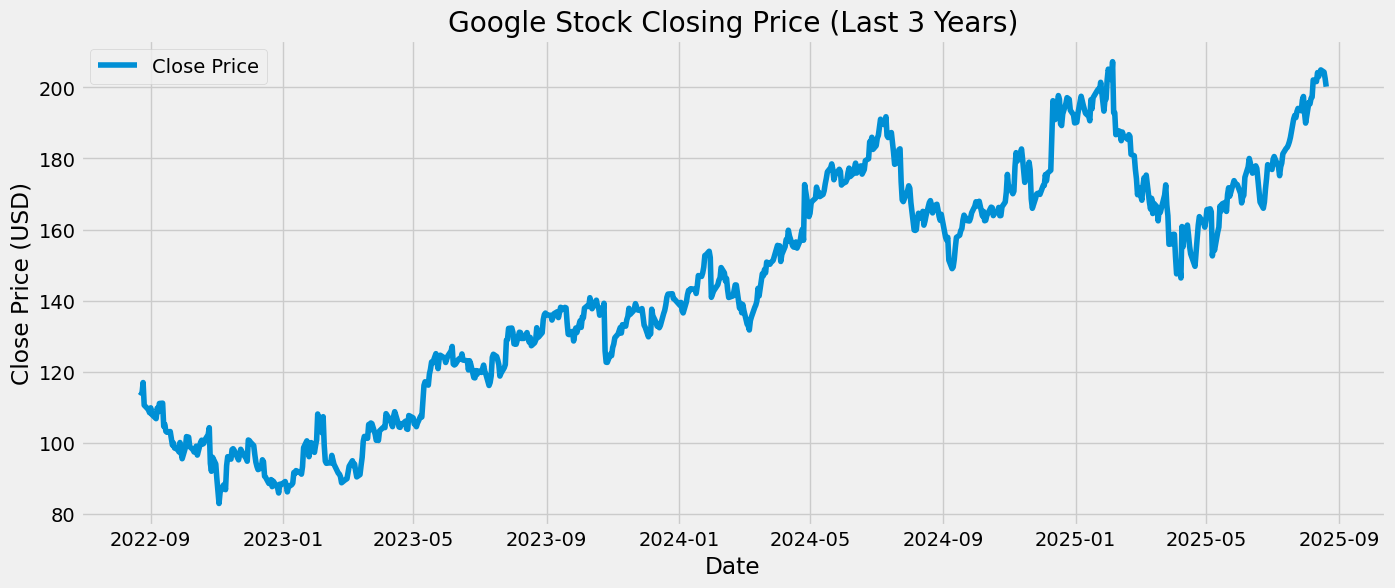

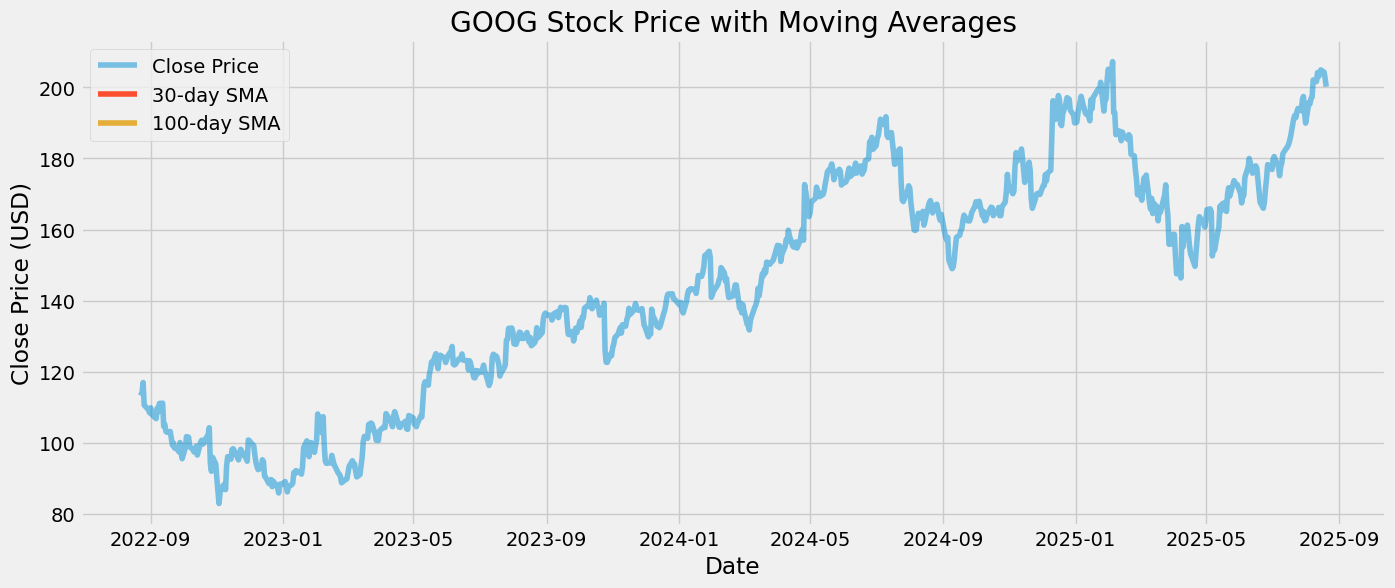

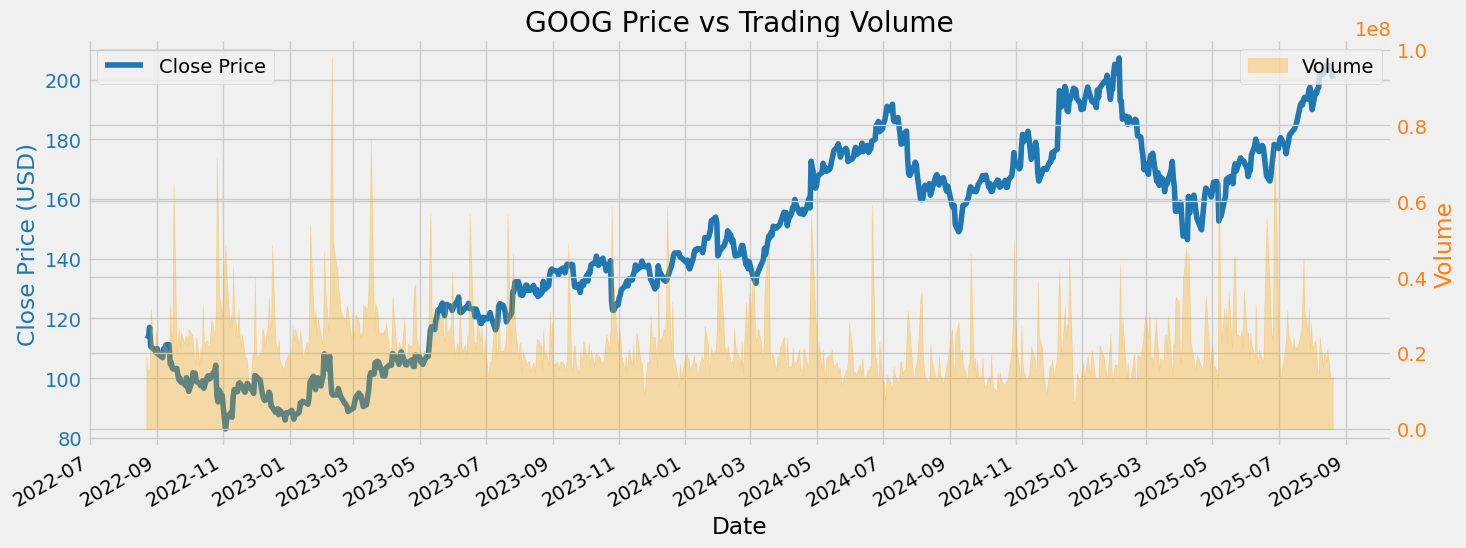

In [28]:
import matplotlib.dates as mdates

# --- Closing Price ---
plt.figure(figsize=(15,6))
plt.plot(data["Date"], data["Close"], label="Close Price")
plt.title("Google Stock Closing Price (Last 3 Years)")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.show()

# --- Moving Averages (Trend Smoothing) ---
data['SMA30'] = data['Close'].rolling(window=30).mean()
data['SMA100'] = data['Close'].rolling(window=100).mean()

plt.figure(figsize=(15,6))
plt.plot(data['Date'], data['Close'], label="Close Price", alpha=0.5)
plt.plot(data['Date'], data['SMA30'], label="30-day SMA")
plt.plot(data['Date'], data['SMA100'], label="100-day SMA")
plt.title("GOOG Stock Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.show()

# --- Price vs Volume ---
fig, ax1 = plt.subplots(figsize=(15,6))

# Price line
ax1.plot(data['Date'], data['Close'], color='tab:blue', label="Close Price")
ax1.set_xlabel("Date")
ax1.set_ylabel("Close Price (USD)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Volume bars (use mdates.date2num to fix error)
ax2 = ax1.twinx()
x = mdates.date2num(data['Date'])
ax2.fill_between(data['Date'], data['Volume'].squeeze(),
                 color='orange', alpha=0.3, label="Volume")

ax2.set_ylabel("Volume", color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Format x-axis as months
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
fig.autofmt_xdate()

# Title and legends
ax1.set_title("GOOG Price vs Trading Volume")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()


## Time Series Decomposition

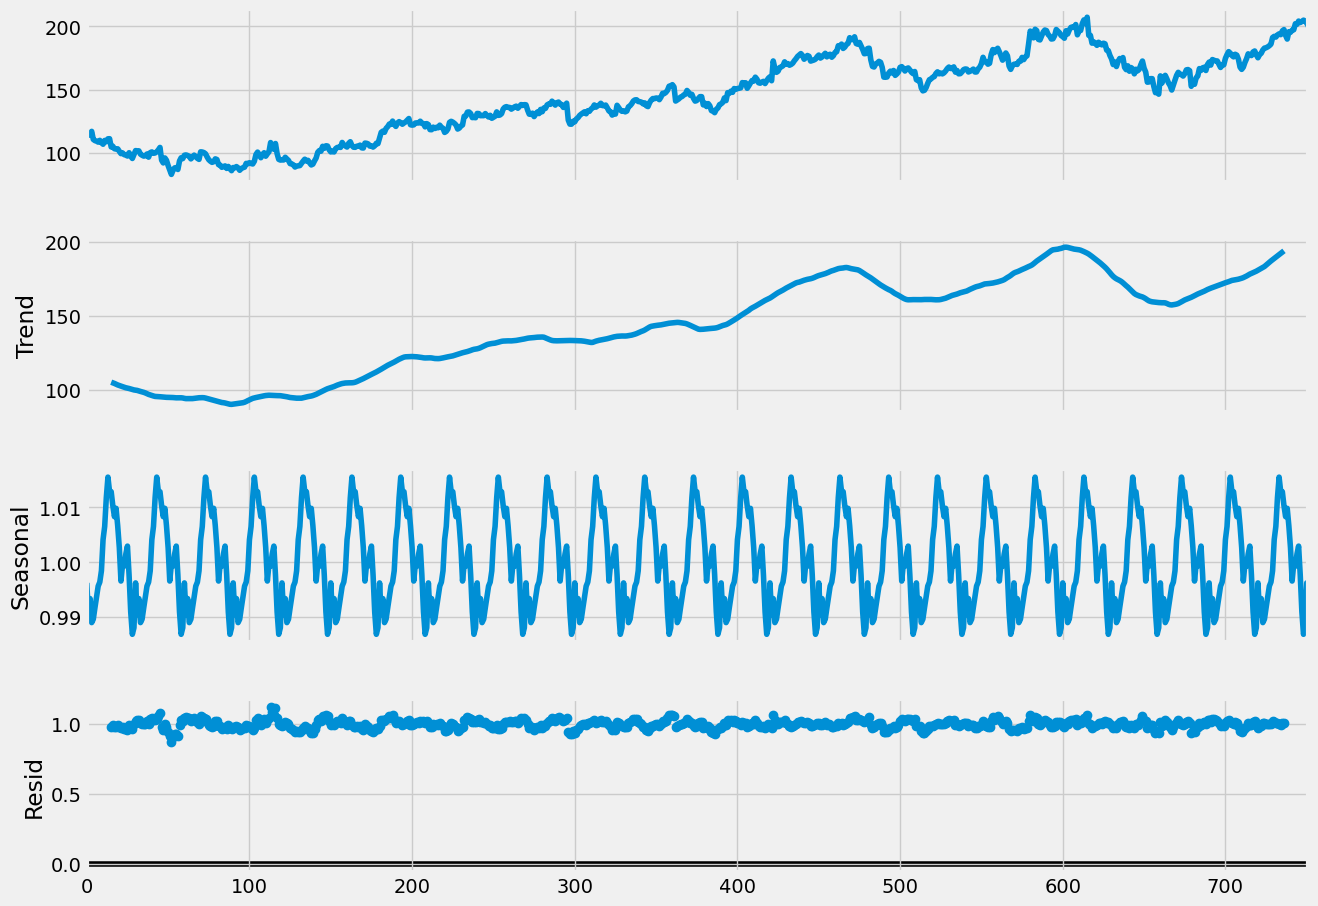

In [31]:
result = seasonal_decompose(data["Close"], model='multiplicative', period=30)
fig = result.plot()
fig.set_size_inches(15,10)

## Stationarity Test

ADF Test Statistic: -0.7175808517006501
p-value: 0.8421429953167111


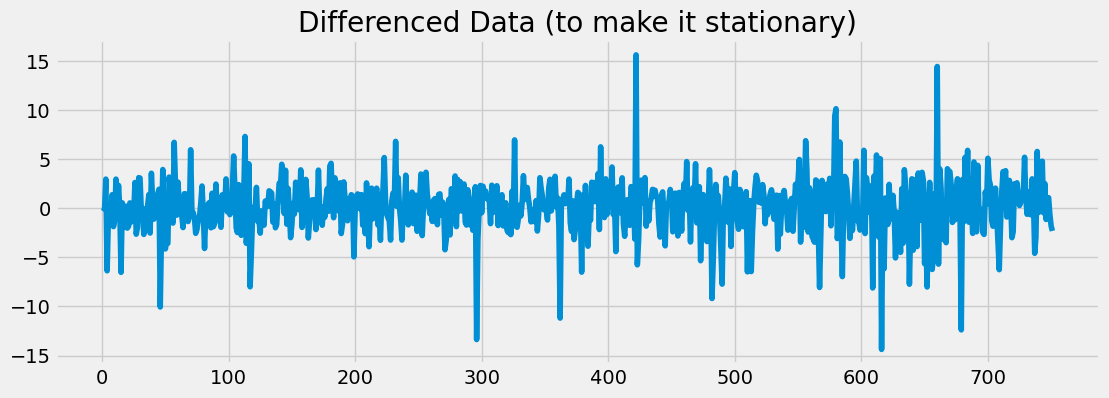

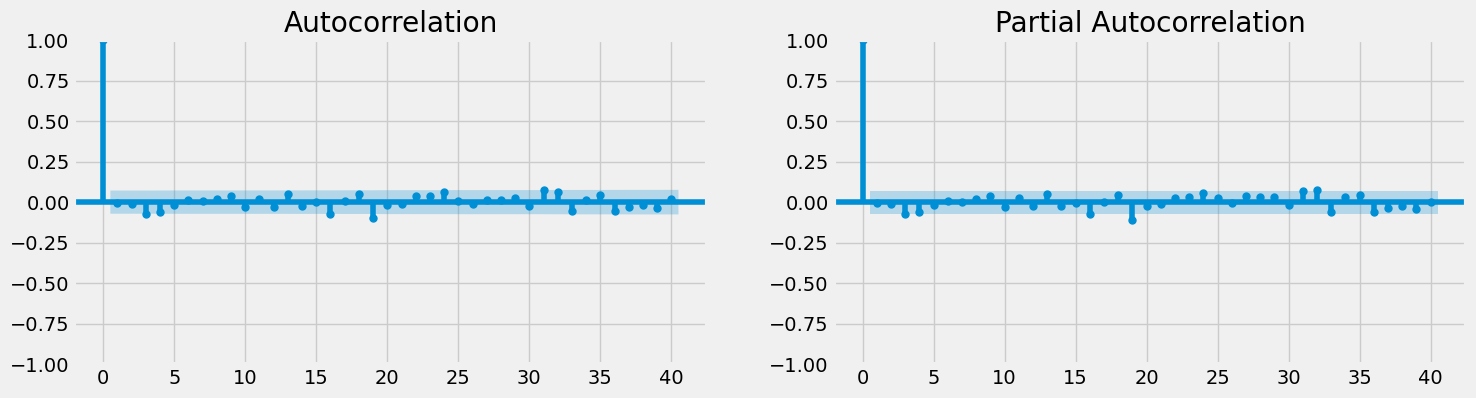

In [34]:
adf_test = adfuller(data['Close'])
print("ADF Test Statistic:", adf_test[0])
print("p-value:", adf_test[1])

# Differencing
diff = data['Close'].diff().dropna()
plt.figure(figsize=(12,4))
plt.plot(diff)
plt.title("Differenced Data (to make it stationary)")
plt.show()

# ACF & PACF
fig, axes = plt.subplots(1,2, figsize=(16,4))
plot_acf(diff, lags=40, ax=axes[0])
plot_pacf(diff, lags=40, ax=axes[1])
plt.show()

## ARIMA / SARIMA Modeling

In [37]:
p = q = 1
d = ndiffs(data['Close'], test='adf')  # auto differencing

model = sm.tsa.statespace.SARIMAX(data['Close'],
                                  order=(p,d,q),
                                  seasonal_order=(p,d,q,12))
model_fit = model.fit()
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               GOOG   No. Observations:                  752
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1831.486
Date:                            Thu, 21 Aug 2025   AIC                           3672.971
Time:                                    04:06:48   BIC                           3695.998
Sample:                                         0   HQIC                          3681.850
                                            - 752                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9879      0.033    -29.678      0.000      -1.053      -0.923
ma.L1          0.9954      0.037   

## Forecasting

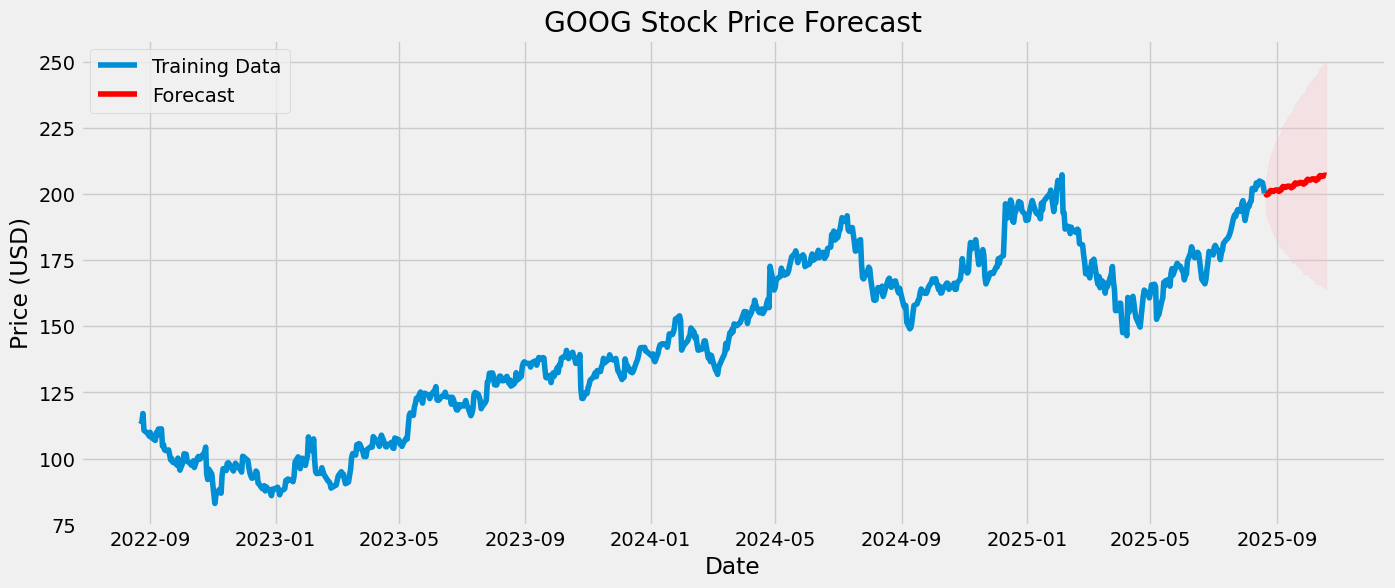

In [40]:
steps = 60  # next 60 days
forecast = model_fit.get_forecast(steps=steps)
forecast_index = pd.date_range(start=data['Date'].iloc[-1], periods=steps+1, freq="D")[1:]
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(15,6))
plt.plot(data['Date'], data['Close'], label="Training Data")
plt.plot(forecast_index, forecast_mean, color="red", label="Forecast")
plt.fill_between(forecast_index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1],
                 color='pink', alpha=0.3)
plt.title("GOOG Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


## Residual Diagnostics & Accuracy check

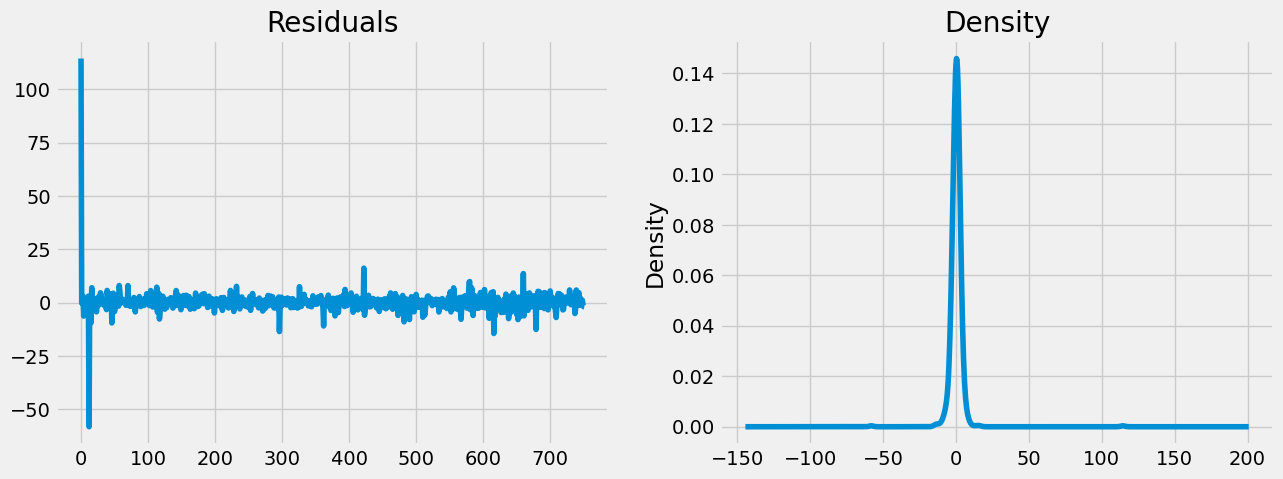

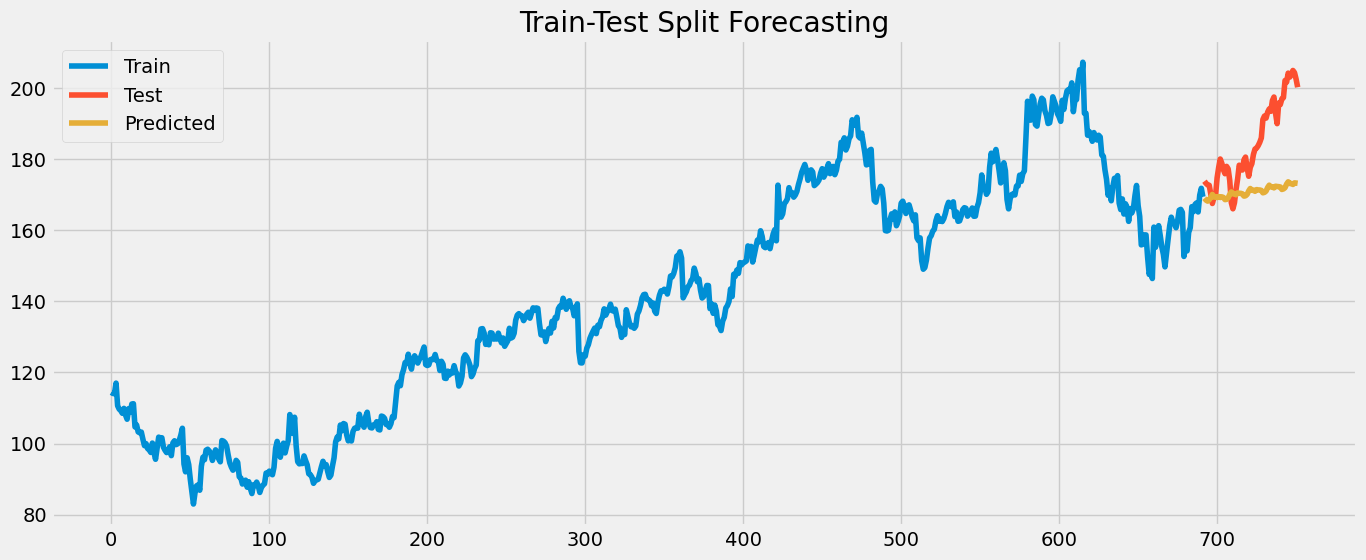

MAE: 13.850446508809464
RMSE: 16.98412445767796


In [43]:
residuals = model_fit.resid
fig, ax = plt.subplots(1,2, figsize=(14,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# ----------------------------
# 8. Accuracy Check (Train-Test Split)
# ----------------------------
train = data['Close'][:-60]
test = data['Close'][-60:]

model = sm.tsa.statespace.SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
fit = model.fit()

pred = fit.get_forecast(steps=60)
pred_mean = pred.predicted_mean

plt.figure(figsize=(15,6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, pred_mean, label="Predicted")
plt.title("Train-Test Split Forecasting")
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error
print("MAE:", mean_absolute_error(test, pred_mean))
print("RMSE:", mean_squared_error(test, pred_mean, squared=False))